# Modelling sequences with RNNs

When we go from sequences of word embeddings to a document-wise vector representation that can be classified, we have to somehow summarize a sequence of vectors into a single vector. So far, what we have been doing is:

1. Get one embedding $e \in \mathbb{R}^{l \times d}$ per token, where  $l$ is the sequence length and $d$ is the embedding dimension. This generates the embedding matrix $E \in \mathbb{R}^{b \times l \times d}$, where $b$ is the batch size.
2. Calculate the timewise mean of $E$, generating $X \in \mathbb{R}^{b \times d}$
3. Proceed to classification with our logist regression.

This is something like this:

```mermaid
graph LR;

    subgraph Embedding;
    D(["Embeddings ($$E \in \mathbb{R}^{b \times l \times d}$$)"])
    end;

    subgraph Summarization;
    D --> E["Mean over time"] --> F(["Embeddings ($$X \in \mathbb{R}^{b \times d}$$)"])
    end;

    subgraph Classification;
    F --> G["Logistic Regression"] --> H(["$$P(C_i=c_j | X_i)$$"])
    end;
```

The problem with this idea is that the calculation of the mean totally disregards the order of the words - essentially, we are doing a glorified bag-of-words modelling, which seems non-ideal. When we do so, we are We could find some other way to summarize our sequence of words so that we somehow account for the order of words.

## Recurrent Neural Networks

Recurrent Neural Networks (RNNs) were diffusely invented by many small contributions during the 1950s to the 1970s. The underlying idea is to begin with a simple logistic regression that receives as input the first time step of $E$, and yields a single prediction $y_0$: 

```mermaid
graph LR;
    F(["Embeddings ($$E \in \mathbb{R}^{b \times l \times d}$$)"]) -->
    FF(["$$x_e = E_{[0,:,:]}$$"])
    FF --> G["Logistic Regression"] --> H([$$y_0$$])
```

In the next prediction, we concatenate the input at step $1$ with the output at the step $0$, that is, we use $x_e = [E_{[1,:,:]}, y_0]$ and get another prediction $y_1$. Then we keep doing this for all time steps $t \in [0, l-1]$. The network starts looking like this:

```mermaid
graph LR;
    F(["Embeddings ($$E \in \mathbb{R}^{b \times l \times d}$$)"])
    FF(["$$x_e = [E_{[t,:,:]}, y_{t-1}]$$"])

    F-->FF
    FF --> G["Logistic Regression"] 

    G --> H([$$y_t$$])

    H -- "Feedback loop" --> FF
```

Now, remember that logistic regression works by using $y=\sigma(z)$, where $z = xw^t+b$. We can change the non-linear function for this purpose - usually, the applied function is $\tanh(z)$. The hyperbolic tangent $\tanh$ can be calculated by:

$$
\tanh(z) = 2\sigma(z)-1.
$$

The advantage of $\tanh$ is that it can assume negative values, which can be useful for optimization. However, when we use $\tanh$ instead of $\sigma$, we no longer have a logistic regression. Instead, we have a linear layer followed by a non-linear function, that is:


```mermaid
graph LR;
    F(["Embeddings ($$E \in \mathbb{R}^{b \times l \times d}$$)"])
    FF(["$$x_e = [E_{[t,:,:]}, y_{t-1}]$$"])

    F-->FF
    FF --> G["$$\tanh(xw^T+b)$$"] 

    G --> H([$$y_t$$])

    H -- "Feedback loop" --> FF
```



The output $y$ is often called "hidden state" and referred to as $h$. This is a reference to the fact that this output is usually a part of a larger classifier, and is hidden because it is an intermediate result of the network (similarly to the intermediate results in a deep MLP).



Typically, RNNs are used to summarize sequences by propagating the last output, that is, our summarization of a sequence of 
 elements is simply $X=y_l$.

Now, note that we have no restriction as to what the dimension of $y$ should be. We could choose to yield, for example, $y_t$ with 50 dimensions, or 500 dimensions. This choice would simply imply in greater dimensions for $x$ and more degrees of freedom in the logistic regression. If this dimension is $d_e$, then $X \in \mathbb{R}^{b \times d_e}.$

Hence, our classifier now works like this:

```mermaid
graph LR;

    subgraph Embedding;
    D(["Embeddings ($$E \in \mathbb{R}^{b \times l \times d}$$)"])
    end;

    subgraph Summarization;
    D-->FF(["$$x_e = [E_{[t,:,:]}, y_{t-1}]$$"])

    FF --> GF["$$\tanh(xw^T+b)$$"] 

    GF --> HF([$$y_t$$])

    HF -- "Feedback loop" --> FF
    HF -- "Last
    State" --> F(["Embeddings ($$X \in \mathbb{R}^{b \times d_h}$$)"])
    end;

    subgraph Classification;
    F --> G["Logistic Regression"] --> H(["$$P(C_i=c_j | X_i)$$"])
    end;
```

The Pytorch implementation of RNN is simply a layer like:

    rnnlayer = nn.RNN(input_size, hidden_size)

We could change our network from the last lesson to:

In [1]:
import torch.nn.functional as F
import torch
import torch.nn as nn

vocab_size = 5000
padding_idx = 3
hidden_dim = 20 # this is dh
embedding_dim = 30 # this is d

class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        self.rnnlayer = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        h, _ = self.rnnlayer(x)
        x = h[:,-1,:]
        x = self.clf(x)
        return x

model = ClassifierWithRNN(vocab_size, hidden_dim, embedding_dim)
print(model)

ClassifierWithRNN(
  (embedding): Embedding(5000, 30, padding_idx=3)
  (rnnlayer): RNN(30, 20, batch_first=True)
  (clf): Linear(in_features=20, out_features=1, bias=True)
)


## Exercise: What happens to embeddings during training?

We will now put everything to use and make some scientific experiments. Feel free to work in groups.

The question is: **what happens to embeddings while we train our network**?

Follow the steps below to find out.

1. Add a method in `ClassifierWithRNN` that receives a token sequence as input (similarly to forward) but returns the result of the summarization.
2. Download the FakeNewsNet dataset from Kagglehub (code is below)
3. Make a `ClassifierWithRNN` with a hidden dimension of $2$. 
4. Calculate document-level embeddings for the elements of the dataset *before* training and show them in a scatter plot. Use colors to represent the classes of each item.
5. Train your classifier.
6. Calculate document-level embeddings for the elements of the dataset *after* training and show them in a scatter plot. Use colors to represent the classes of each item.

What could you observe? Why do you think that is happening?

Now, do it again using the summarization based on mean. What do you observe? Why is that happening?

In [2]:
import kagglehub
import os

print("FakeNewsNet")
fnnpath = kagglehub.dataset_download("algord/fake-news")
print("Path to dataset files:", fnnpteath)
files = os.listdir(fnnpath)
print("Files in dataset path:", files)

FakeNewsNet


100%|██████████| 1.68M/1.68M [00:00<00:00, 2.03MB/s]

Extracting files...
Path to dataset files: /home/joaolucasmbc/.cache/kagglehub/datasets/algord/fake-news/versions/1
Files in dataset path: ['FakeNewsNet.csv']


In [43]:
# Start with this pre-trained tokenizer, so you dont have to train your own:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load('fakenews_tokenizer.model')
padding_idx = sp.piece_to_id('<PAD>')

def pad_to_len(sequences, pad_idx, max_len):
    padded = []
    for s in sequences:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded

In [44]:
class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        self.rnnlayer = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        h, _ = self.rnnlayer(x)
        x = h[:,-1,:]
        x = self.clf(x)
        return x
    
    def summarize(self, x):
        x = self.embedding(x)
        h, _ = self.rnnlayer(x)
        return h[:,-1,:]

In [45]:
model = ClassifierWithRNN(10000, 2, embedding_dim)
print(model)

ClassifierWithRNN(
  (embedding): Embedding(10000, 30, padding_idx=3)
  (rnnlayer): RNN(30, 2, batch_first=True)
  (clf): Linear(in_features=2, out_features=1, bias=True)
)


In [46]:
# Load dataset
import pandas as pd
import numpy as np
from pathlib import Path

df = pd.read_csv(Path(fnnpath) / "FakeNewsNet.csv")

df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [47]:
df = df[["title", "real"]]

In [48]:
from sklearn.model_selection import train_test_split

X = df["title"]
y = df["real"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
tokens = sp.encode_as_ids(list(X))
tokens = pad_to_len(tokens, padding_idx, 1000)
tokens = torch.tensor(tokens)
summarization = model.summarize(tokens)

In [50]:
summarization

tensor([[-0.1890, -0.1031],
        [-0.1890, -0.1031],
        [-0.1890, -0.1031],
        ...,
        [-0.1890, -0.1031],
        [-0.1890, -0.1031],
        [-0.1890, -0.1031]], grad_fn=<SliceBackward0>)

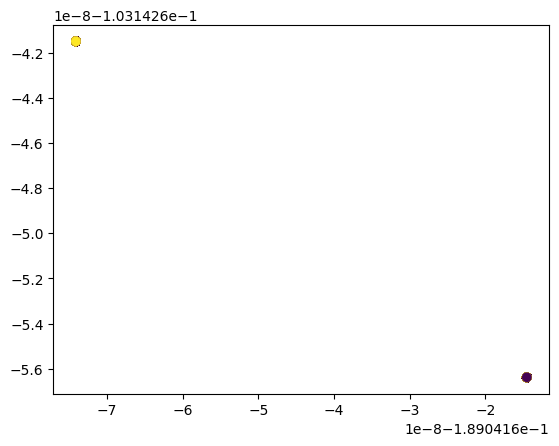

In [51]:
# Plot a scatter plot of the summarization of the titles
import matplotlib.pyplot as plt


plt.scatter(summarization[:,0].detach().numpy(), summarization[:,1].detach().numpy(), c=y)
plt.show()

In [52]:
# Transform the dfs in tensors
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

In [53]:
X_train = sp.encode_as_ids(list(X_train))
X_train = pad_to_len(X_train, padding_idx, 1000)
X_train = torch.tensor(X_train)

X_test = sp.encode_as_ids(list(X_test))
X_test = pad_to_len(X_test, padding_idx, 1000)
X_test = torch.tensor(X_test)

In [56]:
from tqdm import tqdm

# We will also define an optimizer:
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e0)  # lr is the learning rate - this is our alpha

print("Entering loop")
# And now, this is the training loop:
losses = []
model.train()
for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    output = model(X_train)
    loss = torch.mean(
        torch.binary_cross_entropy_with_logits(
            output.flatten().float(),
            y_train.flatten().float(),
        ), )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

Entering loop


100%|██████████| 200/200 [07:48<00:00,  2.34s/it]


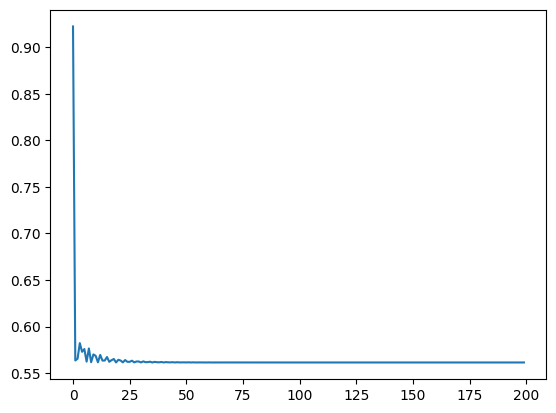

In [57]:
# plot losses
plt.plot(losses)
plt.show()  

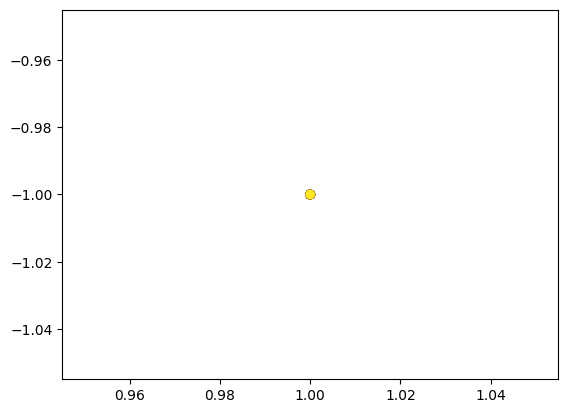

In [58]:
# Summarize all X values and plot them

summarization = model.summarize(tokens)
plt.scatter(summarization[:,0].detach().numpy(), summarization[:,1].detach().numpy(), c=y)
plt.show()

In [ ]:
# This is my solution. DO NOT LOOK AT IT before trying yours.
















class ClassifierWithRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        self.rnnlayer = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=1)
        self.clf = nn.Linear(hidden_dim, 1)
    
    def summarize(self, x):
        x, _ = self.rnnlayer(x)
        x = x[:,-1,:]
        return(x)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.summarize(x)
        x = self.clf(x)
        return x

import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch

df = pd.read_csv(Path(fnnpath) / "FakeNewsNet.csv")
X = df['title']
y = torch.tensor(df['real']).float()
print(len(X), len(y))
tokens = sp.encode_as_ids(list(X))
tokens = pad_to_len(tokens, padding_idx, 30)
tokens = torch.tensor(tokens)
print(tokens.shape, y.shape)
model = ClassifierWithRNN(
    vocab_size=5000,
    hidden_dim=2,
    embedding_dim=2,
).cpu()

model.eval()
embeddings_pre = model.summarize(model.embedding(tokens))

optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3)  # lr is the learning rate - this is our alpha



# And now, this is the training loop:
losses = []


In [ ]:
model.train()
model = model.cuda()
tokens = tokens.cuda()
y = y.cuda()
print("Entering loop")
for epoch in tqdm(range(3000)):
    optimizer.zero_grad()
    output = model(tokens)
    loss = torch.mean(
        torch.binary_cross_entropy_with_logits(
            output.flatten().float(),
            y,
        ))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

model = model.cpu()
tokens = tokens.cpu()
y = y.cpu()
model.eval()
embeddings_post = model.summarize(model.embedding(tokens))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.plot(losses)
plt.show()

In [ ]:
embeddings_pre.shape

In [ ]:
import matplotlib.pyplot as plt

e1 = embeddings_pre.cpu().detach().numpy()
#y = y.cpu().detach().numpy()
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plt.scatter(e1[:,0], e1[:,1], c=y, alpha=0.2)
plt.title("Before training")
plt.subplot(1,2,2)
plt.scatter(embeddings_post.detach().cpu().numpy()[:,0], embeddings_post.detach().cpu().numpy()[:,1], c=y, alpha=0.2)
plt.title("After training")
plt.show()


In [ ]:
embeddings_post[0,:]

# Summary

If everything went well, you should know how to:

1. Make a PyTorch model
1. Use RNNs to summarize the content of sequences
1. Train neural networks with RNNs
1. Use the GPU to speed-up training
1. Visualize the learning curve and diagnose failures with the learning rate
1. Visualize document-level embeddings to check the final state of training